In [1]:
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Get file paths
base_path = 'd:/data/rnp/'
mtrack_paths = get_file_paths(base_path, keyword='mtrack', extension='mat', print_paths=False)
spike_paths = get_file_paths(base_path, keyword='spike_times', extension='mat', print_paths=False)
cluster_paths = get_file_paths(base_path, keyword='cluster_ids', extension='mat', print_paths=False)

spike_paths = filter_paths(spike_paths, mtrack_paths)
cluster_paths = filter_paths(cluster_paths, mtrack_paths)
print(f"Filtered spike paths to {len(spike_paths)} files")
print(f"Filtered cluster paths to {len(cluster_paths)} files")

Found 34 mtrack.mat files
Found 41 spike_times.mat files
Found 41 cluster_ids.mat files
Filtered spike paths to 34 files
Filtered cluster paths to 34 files


In [3]:
# # Check paths by eye, if desired.
# align_test =  pd.DataFrame({'mtrack': mtrack_paths, 'spike_times': spike_paths})
# align_test

In [4]:
# Load a tracking file
mtrack = load_mat_file(mtrack_paths[0]) 

# Load a spike_times file
spike_times = load_mat_file(spike_paths[0]) 
spike_times = spike_times / 30  # Resample to 1000 Hz

# Load a cluster_ids file
cluster_ids = load_mat_file(cluster_paths[0])

# Convert to Pandas and name columns
columns = {0: 'frame_ms', 1: 'head_x', 2: 'body_x', 3: 'head_y', 4: 'body_y'}
mtrack = pd.DataFrame(mtrack)
mtrack = mtrack.rename(columns = columns)

# Get mouse and session ids
session_id = mtrack_paths[0].parts[-2]
mouse_id = mtrack_paths[0].parts[-3]

In [5]:
print(f"spike_times shape: {spike_times.shape}, max: {np.max(spike_times)}, min: {np.min(spike_times)}")
mtrack

spike_times shape: (466502, 1), max: 1969180.5, min: 3.5


,frame_ms,head_x,body_x,head_y,body_y
0,7.0,NaN,NaN,NaN,NaN
1,17.0,NaN,NaN,NaN,NaN
2,27.0,NaN,NaN,NaN,NaN
3,37.0,NaN,NaN,NaN,NaN
4,47.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
196864,1969182.0,791.0,889.0,72.0,39.0
196865,1969182.0,791.0,889.0,72.0,39.0
196866,1969182.0,791.0,889.0,72.0,39.0
196867,1969182.0,791.0,889.0,72.0,39.0


In [6]:
# View available clusters
print(*np.unique(cluster_ids))

0 2 3 4 6 9 10 11 15 16 17 19 24 26 27 29 31 32 33 34 37 38 39 40 41 42 43 48 49 50 51 52 53


In [7]:
# Grab a cluster to test
cluster = 10
cl_idx = np.where(cluster_ids == cluster)[0]

In [8]:
spike_times = spike_times[cl_idx]

# Vectorized approach - much faster than looping
spike_times_flat = spike_times.flatten()
frame_ms_values = mtrack['frame_ms'].values

# Use searchsorted to find insertion points
indices = np.searchsorted(frame_ms_values, spike_times_flat)

# Clip indices to valid range
indices = np.clip(indices, 1, len(frame_ms_values) - 1)

# Check if the left or right neighbor is closer
left_diff = np.abs(spike_times_flat - frame_ms_values[indices - 1])
right_diff = np.abs(spike_times_flat - frame_ms_values[indices])
closest_indices = np.where(left_diff < right_diff, indices - 1, indices)

# Create the result DataFrame directly using vectorized indexing
spike_positions_df = pd.DataFrame({
    'spike_time': spike_times_flat,
    'frame_ms': frame_ms_values[closest_indices],
    'head_x': mtrack['head_x'].values[closest_indices],
    'head_y': mtrack['head_y'].values[closest_indices]
})

spike_positions_df

,spike_time,frame_ms,head_x,head_y
0,1.857973e+04,18583.0,NaN,NaN
1,2.723813e+04,27235.0,NaN,NaN
2,5.290800e+04,52913.0,NaN,NaN
3,6.825393e+04,68258.0,NaN,NaN
4,1.304627e+05,130467.0,NaN,NaN
...,...,...,...,...
410,1.959090e+06,1959093.0,947.0,132.0
411,1.959096e+06,1959093.0,947.0,132.0
412,1.959101e+06,1959103.0,947.0,127.0
413,1.959105e+06,1959103.0,947.0,127.0


Text(0.5, 1.0, 'Trajectory and Spike Positions - Mouse 4122, Session 4 - Cl10')

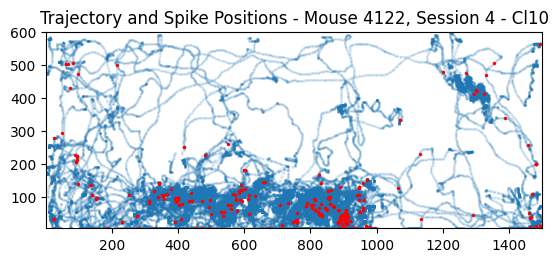

In [9]:
plt.plot(mtrack['head_x'], mtrack['head_y'], marker='o', ms=1, alpha=.1)
plt.scatter(spike_positions_df['head_x'], spike_positions_df['head_y'], marker='o', s=2, color='red', alpha=1, zorder=2)
plt.xlim([mtrack['head_x'].min(), mtrack['head_x'].max()])
plt.ylim([mtrack['head_y'].min(), mtrack['head_y'].max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Trajectory and Spike Positions - Mouse {mouse_id}, Session {session_id} - Cl{cluster}')

In [10]:
# Define grid dimensions
grid_shape = (12, 5)  # 12 bins for x, 5 bins for y

# Define bin edges based on the data range
x_edges = np.linspace(mtrack['head_x'].min(), mtrack['head_x'].max(), grid_shape[0] + 1)
y_edges = np.linspace(mtrack['head_y'].min(), mtrack['head_y'].max(), grid_shape[1] + 1)

# Compute occupancy histogram (time spent in each bin)
occupancy_hist, x_edges, y_edges = np.histogram2d(
    mtrack['head_x'], 
    mtrack['head_y'], 
    bins=[x_edges, y_edges]
)

# Compute spike histogram (number of spikes in each bin)
spike_hist, _, _ = np.histogram2d(
    spike_positions_df['head_x'], 
    spike_positions_df['head_y'], 
    bins=[x_edges, y_edges]
)

print(f"Occupancy histogram shape: {occupancy_hist.shape}")
print(f"Spike histogram shape: {spike_hist.shape}")
print(f"Total occupancy counts: {occupancy_hist.sum()}")
print(f"Total spike counts: {spike_hist.sum()}")

Occupancy histogram shape: (12, 5)
Spike histogram shape: (12, 5)
Total occupancy counts: 172034.0
Total spike counts: 355.0


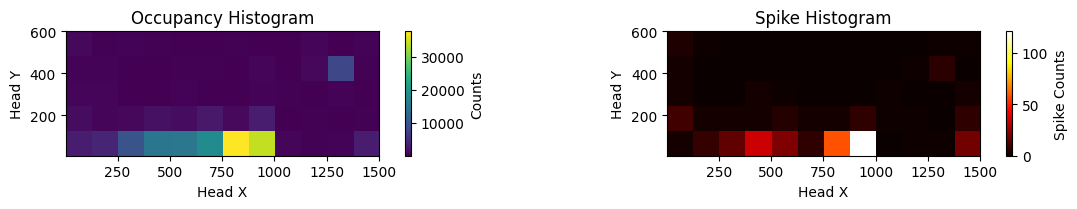

In [11]:
# Plot occupancy histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 2))

# Occupancy histogram
im1 = ax1.imshow(occupancy_hist.T, origin='lower', aspect='equal', cmap='viridis',
                 extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
ax1.set_xlabel('Head X')
ax1.set_ylabel('Head Y')
ax1.set_title('Occupancy Histogram')
plt.colorbar(im1, ax=ax1, label='Counts')

# Spike histogram
im2 = ax2.imshow(spike_hist.T, origin='lower', aspect='equal', cmap='hot',
                 extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
ax2.set_xlabel('Head X')
ax2.set_ylabel('Head Y')
ax2.set_title('Spike Histogram')
plt.colorbar(im2, ax=ax2, label='Spike Counts')

plt.tight_layout()
plt.show()

In [12]:
# Compute spike rate histogram (spikes/sec)
# First, convert occupancy counts to time in seconds
# Each frame represents one timestamp, so we need to know the sampling rate
# From the data, frame_ms is in milliseconds, so we can calculate the time bin duration

# Calculate the time per frame (sampling interval)
frame_diff = np.diff(mtrack['frame_ms'].values[:100])  # Sample first 100 frames
median_frame_interval = np.median(frame_diff)  # in milliseconds
time_per_frame = median_frame_interval / 1000  # convert to seconds

# Convert occupancy histogram from frame counts to time in seconds
occupancy_time = occupancy_hist * time_per_frame

# Set minimum occupancy threshold
min_occupancy_ms = 1000  # milliseconds
min_occupancy_s = min_occupancy_ms / 1000  # convert to seconds

# Compute spike rate (spikes per second)
# Only compute for bins with sufficient occupancy
# Bins that don't meet threshold will be NaN
spike_rate = np.divide(spike_hist, occupancy_time, 
                       out=np.full_like(spike_hist, np.nan, dtype=float), 
                       where=occupancy_time >= min_occupancy_s)

# Count bins that meet the threshold
valid_bins = np.sum(occupancy_time >= min_occupancy_s)
total_bins = occupancy_time.size

print(f"Median frame interval: {median_frame_interval:.2f} ms")
print(f"Time per frame: {time_per_frame:.4f} seconds")
print(f"Minimum occupancy threshold: {min_occupancy_ms} ms")
print(f"Valid bins (>= {min_occupancy_ms} ms): {valid_bins}/{total_bins}")
print(f"Max spike rate: {np.max(spike_rate):.2f} Hz")
print(f"Mean spike rate (valid bins): {np.mean(spike_rate[spike_rate > 0]):.2f} Hz")

Median frame interval: 10.00 ms
Time per frame: 0.0100 seconds
Minimum occupancy threshold: 1000 ms
Valid bins (>= 1000 ms): 54/60
Max spike rate: nan Hz
Mean spike rate (valid bins): 0.42 Hz


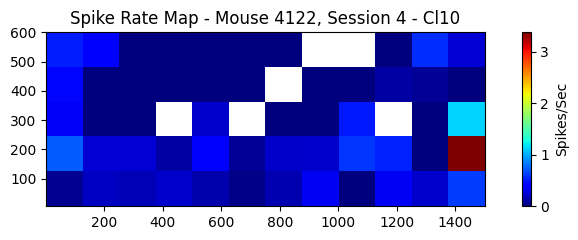

In [13]:
# Plot spike rate histogram
plt.figure(figsize=(8, 2.5))
im = plt.imshow(spike_rate.T, origin='lower', aspect='equal', cmap='jet',
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.title(f"Spike Rate Map - Mouse {mouse_id}, Session {session_id} - Cl{cluster}")
plt.colorbar(im, label='Spikes/Sec')
plt.tight_layout()
plt.show()

In [14]:
# Calculate Skaggs spatial information
# Formula: I = Σ p_i * (r_i / r_mean) * log2(r_i / r_mean)
# where p_i is occupancy probability, r_i is firing rate in bin i

# Flatten arrays for easier computation
spike_rate_flat = spike_rate.flatten()
occupancy_time_flat = occupancy_time.flatten()

# Calculate occupancy probability for each bin
total_time = np.sum(occupancy_time_flat)
p_i = occupancy_time_flat / total_time

# Calculate mean firing rate (weighted by occupancy)
# Only include bins that meet the threshold (non-NaN values)
valid_mask = ~np.isnan(spike_rate_flat)
r_mean = np.sum(spike_rate_flat[valid_mask] * p_i[valid_mask]) / np.sum(p_i[valid_mask])

# Calculate spatial information
# Only compute for valid bins with non-zero firing rates
spatial_info = 0
for i in range(len(spike_rate_flat)):
    if valid_mask[i] and spike_rate_flat[i] > 0:
        ratio = spike_rate_flat[i] / r_mean
        spatial_info += p_i[i] * ratio * np.log2(ratio)

print(f"Mean firing rate: {r_mean:.3f} Hz")
print(f"Skaggs spatial information: {spatial_info:.3f} bits/spike")

Mean firing rate: 0.206 Hz
Skaggs spatial information: 0.380 bits/spike


In [15]:
# Compute SSI (Significance of Spatial Information) using circular shuffle permutation test
n_permutations = 1000
null_si_distribution = np.zeros(n_permutations)

# Get the total recording duration
recording_duration = mtrack['frame_ms'].max() - mtrack['frame_ms'].min()

print(f"Running {n_permutations} permutations...")

for perm in range(n_permutations):
    # Randomly shift spike times circularly
    shift_amount = np.random.uniform(0, recording_duration)
    shifted_spike_times = spike_times_flat + shift_amount
    
    # Wrap around for circular shift
    shifted_spike_times = np.where(shifted_spike_times > mtrack['frame_ms'].max(), 
                                    shifted_spike_times - recording_duration, 
                                    shifted_spike_times)
    
    # Find closest positions for shifted spikes
    shifted_indices = np.searchsorted(frame_ms_values, shifted_spike_times)
    shifted_indices = np.clip(shifted_indices, 1, len(frame_ms_values) - 1)
    
    # Check if left or right neighbor is closer
    left_diff_shift = np.abs(shifted_spike_times - frame_ms_values[shifted_indices - 1])
    right_diff_shift = np.abs(shifted_spike_times - frame_ms_values[shifted_indices])
    shifted_closest = np.where(left_diff_shift < right_diff_shift, shifted_indices - 1, shifted_indices)
    
    # Compute spike histogram for shifted data
    shifted_spike_hist, _, _ = np.histogram2d(
        mtrack['head_x'].values[shifted_closest],
        mtrack['head_y'].values[shifted_closest],
        bins=[x_edges, y_edges]
    )
    
    # Compute spike rate for shifted data
    shifted_spike_rate = np.divide(shifted_spike_hist, occupancy_time, 
                                    out=np.full_like(shifted_spike_hist, np.nan, dtype=float), 
                                    where=occupancy_time >= min_occupancy_s)
    
    # Calculate Skaggs SI for this permutation
    shifted_rate_flat = shifted_spike_rate.flatten()
    shifted_valid_mask = ~np.isnan(shifted_rate_flat)
    shifted_r_mean = np.sum(shifted_rate_flat[shifted_valid_mask] * p_i[shifted_valid_mask]) / np.sum(p_i[shifted_valid_mask])
    
    perm_si = 0
    for i in range(len(shifted_rate_flat)):
        if shifted_valid_mask[i] and shifted_rate_flat[i] > 0:
            ratio = shifted_rate_flat[i] / shifted_r_mean
            perm_si += p_i[i] * ratio * np.log2(ratio)
    
    null_si_distribution[perm] = perm_si
    
    if (perm + 1) % 100 == 0:
        print(f"  Completed {perm + 1}/{n_permutations} permutations")

# Calculate statistics
null_mean = np.mean(null_si_distribution)
null_std = np.std(null_si_distribution)
z_score = (spatial_info - null_mean) / null_std
is_significant = z_score >= 3

print(f"\nOriginal SI: {spatial_info:.3f} bits/spike")
print(f"Null distribution mean: {null_mean:.3f} bits/spike")
print(f"Null distribution std: {null_std:.3f}")
print(f"Z-score: {z_score:.3f}")
print(f"Significant (z >= 3): {is_significant}")

Running 1000 permutations...
  Completed 100/1000 permutations
  Completed 200/1000 permutations
  Completed 300/1000 permutations
  Completed 400/1000 permutations
  Completed 500/1000 permutations
  Completed 600/1000 permutations
  Completed 700/1000 permutations
  Completed 800/1000 permutations
  Completed 900/1000 permutations
  Completed 1000/1000 permutations

Original SI: 0.380 bits/spike
Null distribution mean: 0.466 bits/spike
Null distribution std: 0.123
Z-score: -0.699
Significant (z >= 3): False


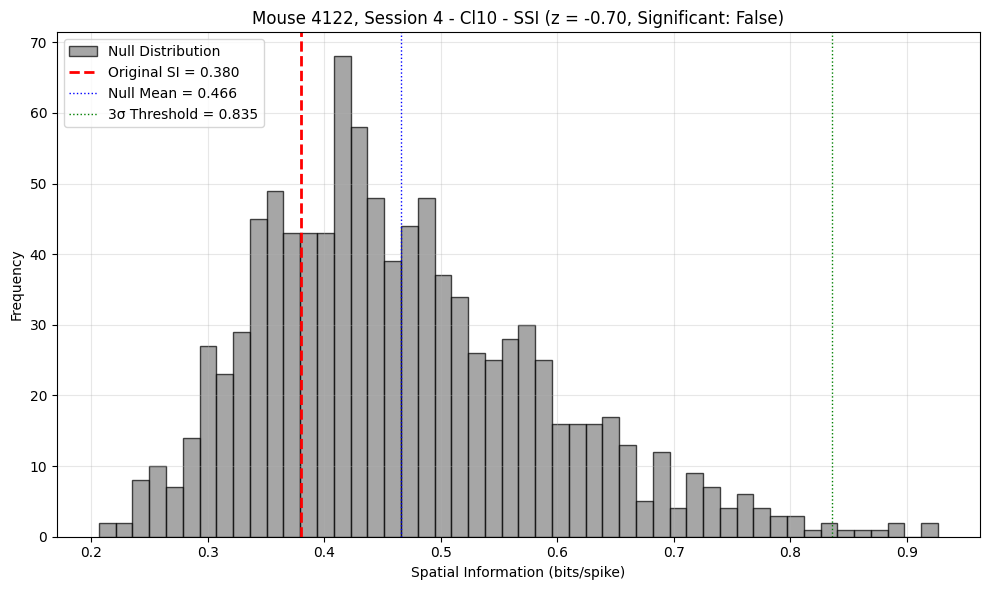

In [17]:
# Plot null distribution with original SI value
plt.figure(figsize=(10, 6))
plt.hist(null_si_distribution, bins=50, alpha=0.7, color='gray', edgecolor='black', label='Null Distribution')
plt.axvline(spatial_info, color='red', linewidth=2, linestyle='--', label=f'Original SI = {spatial_info:.3f}')
plt.axvline(null_mean, color='blue', linewidth=1, linestyle=':', label=f'Null Mean = {null_mean:.3f}')
plt.axvline(null_mean + 3*null_std, color='green', linewidth=1, linestyle=':', label=f'3σ Threshold = {null_mean + 3*null_std:.3f}')
plt.xlabel('Spatial Information (bits/spike)')
plt.ylabel('Frequency')
plt.title(f'Mouse {mouse_id}, Session {session_id} - Cl{cluster} - SSI (z = {z_score:.2f}, Significant: {is_significant})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()